# Plot NO


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import iris
from ncdata.iris_xarray import cubes_to_xarray
import STASH_fields_defs as def_STASH

In [2]:
color_scheme = {"ukesm11": "#E69F00", "ukesm13": "#56B4E9"}

In [3]:
M_NO = 30.01 * 1e-3  # kg/mol
M_AIR = 28.97 * 1e-3  # kg/mol
N_A = 6.10e23  # molec/mol

In [4]:
def load_data(filename_glob):
    """
    Load data using filename_glob into xarray dataset.
    """
    file_list = [xr.open_mfdataset(f, engine="netcdf4") for f in filename_glob]
    dataset = xr.combine_by_coords(
        file_list, join="outer", combine_attrs="drop_conflicts"
    )

    dataset = dataset  # .rename(rename_dict_ukca)
    return dataset

In [5]:
def pressure_from_height(heights_m):
    # rough conversion from metre to hPa
    # https://en.wikipedia.org/wiki/Pressure_altitude

    p_hPa = 1013.25 * np.exp(-heights_m / 8431)
    return p_hPa

In [6]:
def get_mean(data, season):
    """Return zonal mean for a season or annual."""
    if season != "Annual":
        sel = data.sel(time=data["time"][data["time.season"] == season])
        mean = sel.mean("time").mean("lon").load()
    else:
        mean = data.mean("time").mean("lon").load()
    return mean

In [7]:
# Load obs data

obs_root = "/gws/nopw/j04/ukca_vol2/Observational_datasets/ObsData/"
obs_files = ["ACE-FTS/NO/ACE_monthly_zm_NO_hpa_eql_*_all.nc"]

obs_paths = [f"{obs_root}{f}" for f in obs_files]

obs = load_data(obs_paths)

In [8]:
# Load model data

data_root_path = "/gws/nopw/j04/terrafirma/dgrosven/UKESM1.3_eval_July2025/model_output/u-dr061/atomic_output/"

variables = [
    "34002/apm.pp/*.pp",  # NO
    # "34081/apm.pp/*.pp",  # OH
    # "34003/apm.pp/*.pp",  # NO3
    # "34996/apm.pp/*.pp",  # NO2
    # "50062/apm.pp/*.pp",  # airmass
    # "50063/apm.pp/*.pp",  # tropmask
]

model_path = [f"{data_root_path}{v}" for v in variables]

iris_cube = iris.load(model_path, callback=def_STASH.UKCA_callback)

# ensure dataset-level and variable-level attributes loaded correctly
iris.FUTURE.save_split_attrs = True

ds = cubes_to_xarray(iris_cube)
ds = (
    ds.assign_coords({"p_hPa": pressure_from_height(ds["level_height"])})
    .rename({"latitude": "lat", "longitude": "lon"})
    .swap_dims({"model_level_number": "p_hPa"})
)

/home/users/vs480/.conda/envs/cmip6-env/lib/python3.9/site-packages/iris/fileformats/rules.py:338: IrisUserWarning: Unable to create instance of HybridHeightFactory. The source data contains no field(s) for 'orography'.
  warnings.warn(


In [9]:
# Interpolate model data to coarser observation data resolutions
ds = ds.interp(lat=obs["lat"], p_hPa=obs["plev"])

In [10]:
# compute zonal mean
seasons = ["DJF", "MAM", "JJA", "SON"]

no_kgkg_seasonal = {s: get_mean(ds["no"], s) for s in seasons + ["Annual"]}

In [11]:
month_slice = {
    "DJF": [12, 1, 2],
    "MAM": [3, 4, 5],
    "JJA": [6, 7, 8],
    "SON": [9, 10, 11],
}

obs_seasonal = {s: obs["NO"].sel(time=month_slice[s]).mean(dim="time") for s in seasons}
obs_seasonal["Annual"] = obs["NO"].mean(dim="time")

In [12]:
obs["NO"].isel(time=0, lat=0).load()

<xarray.DataArray 'NO' (plev: 48)>
array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan, 2.98529453e-11,            nan, 8.45292655e-11,
       1.08576870e-10, 9.39459772e-11, 1.36302712e-10, 1.21124657e-10,
       1.51979026e-10, 5.57591030e-10, 1.58152432e-09, 2.62269394e-09,
       5.24548120e-09,            nan,            nan,            nan,
                  nan,            nan, 7.96244054e-09, 7.30964486e-09,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan])
Coordinates:
    lat      float64 -87.5
  * plev     (plev) float64 1e+03 850.0 700.0 500.0 ... 0.0003 0.0002 0.0001
    time     float64 1.0
Attributes:
    long_name:    NO
    description:  volume mixing ratio of NO in air
    units:        ppv

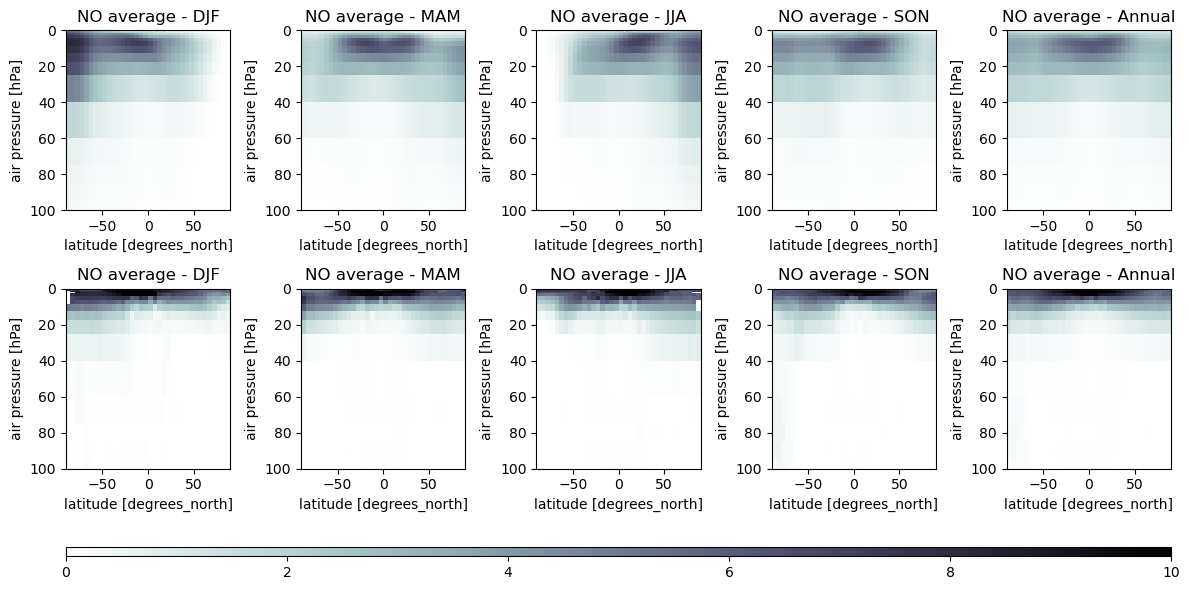

In [13]:
fig_width = 12
widths_subplot = [1, 1, 1, 1, 1]
heights_subplot = [1, 1, 0.05]
fig = plt.figure(figsize=(fig_width, 0.5 * fig_width))

nrow = len(heights_subplot)
ncol = len(widths_subplot)

gs = fig.add_gridspec(
    nrow, ncol, width_ratios=widths_subplot, height_ratios=heights_subplot
)
axs = [fig.add_subplot(gs[i, j]) for i in range(nrow - 1) for j in range(ncol)]


for i, s in enumerate(seasons + ["Annual"]):
    ax = axs[i]
    plot_data = no_kgkg_seasonal[s] * M_AIR / M_NO * 1e9
    heatmap = plot_data.plot(
        ax=ax,
        add_colorbar=False,
        vmin=0,
        vmax=10,
        cmap=plt.cm.bone_r,
    )
    ax.set_ylim(100, 0)
    ax.set_title(f"NO average - {s}")

for i, s in enumerate(seasons + ["Annual"]):
    ax = axs[i + 5]
    plot_data = obs_seasonal[s] * 1e9
    plot_data.plot(
        ax=ax,
        x="lat",
        add_colorbar=False,
        vmax=10,
        vmin=0,
        cmap=plt.cm.bone_r,
    )
    ax.set_ylim(100, 0)
    ax.set_title(f"NO average - {s}")

clb_ax = fig.add_subplot(gs[-1, :])
clb = fig.colorbar(heatmap, cax=clb_ax, extend="neither", orientation="horizontal")
# clb.ax.set_xlabel(f"Aerosol mass loading" + " [$\mu$g m$^{-2}$]")

fig.tight_layout()